In [1]:
import numpy as np 
import pandas as pd
import pystan
import stan_utility
import scipy
import _pickle as cPickle


import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
import os

# to render plots with white background
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.2)

from mpl_toolkits.axes_grid.anchored_artists import AnchoredText




# TrialStart = 0, 1. much more TrialStart == 0 than ==1 
# First lick: Reward Enter
# Next lick: Reward Exit (after they havne't licked for a while) -- not super reliable 

/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [2]:
def inv_logit(arr):
    '''Elementwise inverse logit (logistic) function.'''
    return 1 / (1 + np.exp(-arr))

def phi_approx(arr):
    '''Elementwise fast approximation of the cumulative unit normal. 
    For details, see Bowling et al. (2009). "A logistic approximation 
    to the cumulative normal distribution."'''
    return inv_logit(0.07056 * arr ** 3 + 1.5976 * arr)


# def softmax(x):
#     """
#     Compute softmax values for each sets of scores in x.
    
#     Rows are scores for each class. 
#     Columns are predictions (samples).
#     """
#     scoreMatExp = np.exp(np.asarray(x))
#     return scoreMatExp / scoreMatExp.sum(0)

In [6]:
# data = pd.read_csv('./data/dan_table.csv')
data = pd.read_csv('./data/rachel_table.csv', names = ['gcamp', 'TrialStart', 'NosePokeEnter', 'NosePokeExit', 'LeverPresentation',
                                                       'IpsLeverPress', 'ConLeverPress', 'CSplus', 'CSneg', 'RewardEnter',
                                                       'RewardExit', 'MouseID', 'RecordLoc', 'Session'])

data_g = pd.read_csv('./data/dan_table.csv')

data['gcamp'] = data_g['gcamp']

data = data[(data['RecordLoc'] != 5) ]

# Somehow the length of data is different for different RecordLoc... I'm going to use DMS since I'll want to 
# model the neural data from that area later 
#         1 = VTA/SNc -> Dorsomedial Striatum
#         2 = VTA/SNc -> Nucleus Accumbens
#         3 = VTA/ SNc -> Dorsolateral Striatum (forgot i had these)
#         4 = VTA/ SNc -> Dorsomedial Striatum Cell Bodies
#         5 = GFP controls (DMS and NAc together)

In [7]:
# pull out trial by trial info 

data_t = []

for mouse_id in np.unique(data['MouseID']):
    data_small = data[data['MouseID'] == mouse_id]

    trial_starts = np.where(data_small['TrialStart'] == 1)[0]
    num_trials = len(trial_starts)

    for t_i, t in enumerate(trial_starts):

        if t_i == (num_trials - 1):
            trial_end = len(data_small)
        else:
            trial_end = trial_starts[t_i + 1]

        trial_df = data_small[t:trial_end];

#         lever_press = np.where(trial_df['LeverPresentation'] == 1)[0][0]
        if sum(trial_df.IpsLeverPress.values) >  sum(trial_df.ConLeverPress.values):
            action = 'Ips'
        else:
            action = 'Con'

        if sum(trial_df.CSplus.values) >  sum(trial_df.CSneg.values):
            reward = 1
        else:
            reward = 0

        sess = np.unique(trial_df['Session'])[0]
        recordloc = np.unique(trial_df['RecordLoc'])[0]
        data_t.append([ mouse_id - 1, t_i, action, reward, t , sess, recordloc]) #  lever_press])

  

In [8]:
df_trials = pd.DataFrame(data_t, columns = ('MouseID', 'Trial', 'Action', 'Reward', 'TrialStart',
                                             'Session', 'RecordLoc'))
                


In [9]:
NS = len(np.unique(df_trials['MouseID']))

NT = max(df_trials.groupby('MouseID').count()['Trial'])
NT_all = df_trials.groupby('MouseID').count()['Trial']

c_str = np.empty([NS, NT], 'str')
r = np.empty([NS, NT], int)
r.fill(-1) # init with nan to ensure that shorter trials dont' get false data 
for i, s in enumerate(np.unique(df_trials['MouseID'])):
    c_str[i, :NT_all[s]] = (df_trials[df_trials['MouseID'] == s])['Action'].values
    r[i, :NT_all[s]] = (df_trials[df_trials['MouseID'] == s])['Reward'].values
    
c = np.empty([NS, NT], int)
c.fill(-1)

c[c_str == 'C'] = 0; 
c[c_str == 'I'] = 1;  


standata = {'NS':NS,'NT':NT,'NT_all':NT_all, 
           'r':r, 'c':c}

# pystan.stan_rdump(standata, 'rl_behavioral.data.R')
# pickle.dump( standata, open( "standata.p", "wb" ) )

# intercept for side

In [ ]:
fit = pystan.stan(file = 'stan/qlearning_intercept_side.stan',data=standata, iter=1000, warmup=250, chains=4, 
                  control=dict(adapt_delta = 0.9999))

In [ ]:
# fit = pystan.stan(file = 'stan/qlearning2_checkfit.stan',data=standata, iter=1000, warmup=250, chains=4, 
#                   control=dict(adapt_delta = 0.9999))

# fit = sm.sampling( data=standata, iter=1000, warmup=250, chains=4, 
#                  seed = 4, control=dict(adapt_delta = 0.9999))

In [ ]:
# stan_utility.check_treedepth(fit); stan_utility.check_energy(fit); stan_utility.check_div(fit)
# print(fit)

In [ ]:
# ## Save summary file.
# summary = fit.summary()
# summary = pd.DataFrame(summary['summary'], columns=summary['summary_colnames'], index=summary['summary_rownames'])
# summary.to_csv(os.path.join('data/', 'summary_full_seed4.csv'))

# # Save contents of StanFit.
# extract = fit.extract()
# for k, v in standata.items(): extract[k] = v
# with open(os.path.join('data/' 'StanFit_full_seed4.pickle'), 'wb') as fn: cPickle.dump(extract, fn)

# intercept for last action


In [ ]:
# fit2 = pystan.stan(file = 'stan/qlearning_intercept_last.stan',data=standata, iter=1000, warmup=250, chains=4, 
#                   control=dict(adapt_delta = 0.99))

In [ ]:
stan_utility.check_treedepth(fit2); stan_utility.check_energy(fit2); stan_utility.check_div(fit2)
print(fit2)

In [ ]:
# ## Save summary file.
# summary = fit2.summary()
# summary = pd.DataFrame(summary['summary'], columns=summary['summary_colnames'], index=summary['summary_rownames'])
# summary.to_csv(os.path.join('data/', 'summary_int_pc.csv'))

# # Save contents of StanFit.
# extract = fit2.extract()
# for k, v in standata.items(): extract[k] = v
# with open(os.path.join('data/' 'StanFit_int_pc.pickle'), 'wb') as fn: cPickle.dump(extract, fn)

# Analysis of fit

In [3]:
import pickle
extract = pickle.load( open( "data/StanFit_int_pc.pickle", "rb" ) )
summary = pd.DataFrame.from_csv("data/summary_int_pc.csv")

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  app.launch_new_instance()


In [4]:
summary

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
betam,0.991831,0.001914,0.104817,0.785806,0.926501,0.990275,1.058405,1.204639,3000.0,1.000840
alpham,0.280245,0.002688,0.125308,0.015506,0.205782,0.283441,0.357970,0.521426,2173.0,0.999823
staym,0.946621,0.001909,0.104576,0.742629,0.883670,0.945385,1.008465,1.163876,3000.0,0.999867
betasd,0.335896,0.001608,0.088088,0.207180,0.273766,0.323315,0.381547,0.542784,3000.0,1.000864
alphasd,0.344023,0.003802,0.133464,0.142716,0.250423,0.325971,0.416741,0.669016,1232.0,1.003453
staysd,0.340301,0.001565,0.085730,0.214879,0.280670,0.328428,0.383207,0.550083,3000.0,1.001274
betas[0],1.379926,0.001465,0.080263,1.228311,1.326660,1.378630,1.432049,1.537987,3000.0,1.000165
betas[1],1.177025,0.001428,0.078231,1.026434,1.124913,1.177907,1.226203,1.331797,3000.0,0.999350
betas[2],0.930249,0.001186,0.064948,0.807819,0.886897,0.929059,0.972513,1.057845,3000.0,0.999029
betas[3],1.098245,0.001162,0.063654,0.976399,1.055412,1.098440,1.139053,1.223629,3000.0,0.999604


NameError: name 'NS' is not defined

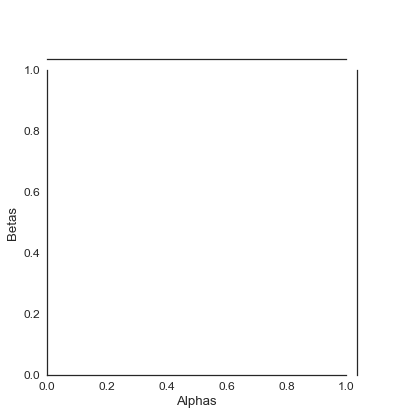

In [4]:
dummy = pd.DataFrame([[0, 0, 0]], columns = ('Alphas', 'Betas', 'Stay Intercept'))
alphas = extract['alphas']
betas = extract['betas']
g = sns.JointGrid("Alphas", "Betas", dummy) 

for s in np.arange(NS):
    
    sns.kdeplot(alphas[:,s], ax=g.ax_marg_x, legend=False)
    sns.kdeplot(betas[:,s], ax=g.ax_marg_y, vertical=True, legend = False) 
    g.ax_joint.plot(alphas[:,s], betas[:,s], 'o', ms=5, alpha = 0.5, label = 'Mouse {:d}'.format(s))
    

g.ax_joint.legend(bbox_to_anchor=(1.2, 1), loc=2, borderaxespad=0.)


In [ ]:
dummy = pd.DataFrame([[0, 0, 0]], columns = ('Alphas', 'Betas', 'Stay'))
alphas = extract['stay']
betas = extract['betas']
g = sns.JointGrid("Stay", "Betas", dummy) 

for s in np.arange(NS):
    
    sns.kdeplot(alphas[:,s], ax=g.ax_marg_x, legend=False)
    sns.kdeplot(betas[:,s], ax=g.ax_marg_y, vertical=True, legend = False) 
    g.ax_joint.plot(alphas[:,s], betas[:,s], 'o', ms=5, alpha = 0.5, label = 'Mouse {:d}'.format(s))
    

g.ax_joint.legend(bbox_to_anchor=(1.2, 1), loc=2, borderaxespad=0.)


In [5]:
for s in np.arange(NS):
    plt.hist(extract['stay'][:,s], 100, alpha = 0.8, label = 'Mouse {:d}'.format(s))

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Stay Intercept Distributions for Each Subject')

NameError: name 'NS' is not defined

In [10]:
%%time 
# get the predictions: 
N_samples = np.shape(extract['betas'])[0]


Q_i = np.zeros((N_samples, NS, (NT + 1)), float)
Q_c = np.zeros((N_samples, NS, (NT + 1)), float)
delta = np.zeros((N_samples, NS, NT), float)

for s in np.arange(NS):

    for t in np.arange(extract['NT_all'][s]):

        r_i = extract['r'][s, t]
        c_i = extract['c'][s, t]

        if c_i == 0: # contra choice
            Q_choice = Q_c; 
            Q_other = Q_i; 
        elif c_i == 1: # ipsa choice
            Q_choice = Q_i; 
            Q_other = Q_c; 
            
        delta[:, s, t] = r_i - Q_choice[:, s, t] 
        
        
        # Q of the choice is updated, the other one is not. 
        Q_choice[:, s, t + 1] = Q_choice[:, s, t] + phi_approx(extract['alphas'][:,s]) * delta[:, s, t]
        Q_other[:, s, t + 1] = Q_other[: ,s, t]
        




_Q_i = np.mean(Q_i, 0)
_Q_c = np.mean(Q_c, 0)

CPU times: user 37.6 s, sys: 6.99 s, total: 44.6 s
Wall time: 1min 4s


In [13]:
%%time
prob_ipsa = np.zeros((N_samples, NS, NT))
prob_contra = np.zeros((N_samples, NS, NT))


pc = np.zeros((NS, NT))
pc[:, 1:NT_all[s]] = c[:, :(NT_all[s] - 1)] * 2 - 1

for s in np.arange(NS):

    betas_i = extract['betas'][:,s]
    stay_i = extract['stay'][:,s]
    
    intercept_pc = stay_i[:, np.newaxis] * pc[np.newaxis, s, :NT_all[s]]
    
    ipsa = betas_i[:, np.newaxis]  * Q_i[:, s, :NT_all[s]] 
    contra = betas_i[:, np.newaxis]  * Q_c[:, s, :NT_all[s]] 
    prob_ipsa[:, s, :NT_all[s]] = 1 / (1 + np.exp(contra - ipsa + intercept_pc) )
    prob_contra[:, s, :NT_all[s]] = 1 / (1 + np.exp(ipsa - contra + intercept_pc) )


_prob_ipsa = np.mean(prob_ipsa, axis = 0)
_prob_contra = np.mean(prob_contra, axis = 0)

CPU times: user 11.4 s, sys: 13 s, total: 24.4 s
Wall time: 29.5 s


In [14]:
_prob_choice = np.zeros((NS, NT))

_prob_choice[c == 0] = _prob_contra[c == 0]
_prob_choice[c == 1] = _prob_ipsa[c == 1]
        

In [77]:
# calculating the pseudo R^2, as defined as: 
# psuedo_r = 1 - log(L_c) / log(L_null)
# for L_null, we will define as: sum(log(total_ipsi/total_trials)) + sum(log(total_contra/total_trials))
stayed = (c[:, :-1] == c[:, 1:]).astype(int)

psuedo_r = []
for s in np.arange(NS):

    num_stayed = sum(stayed[s, :(NT_all[s] - 1)] == 1)
    num_left = sum(stayed[s, :(NT_all[s] - 1)] == 0)
    log_L_null = np.log(0.5) +  (np.log(num_stayed/(num_left + num_stayed)) * num_stayed) + (np.log(num_left/(num_left + num_stayed)) * num_left)

    log_L_c = sum(np.log(_prob_choice[s, :NT_all[s]]))
    
    if log_L_null == 0: 
        import pdb; pdb.set_trace()

    psuedo_r.append(1 - (log_L_c / log_L_null))
    



In [78]:
psuedo_r

[-0.44077625054711489,
 -0.38011248509652917,
 -0.053432797497120266,
 -0.0556136175509232,
 -0.14217907020695342,
 -0.068337334067650968,
 -0.47417766477859424,
 -0.56423908219890451,
 -0.11518552071363897,
 -0.20398542490310745,
 -0.66808357770355831,
 -0.14029069600393518]

In [73]:
NT_all[0]

4525

In [71]:
log_L_c

-2972.3149498006478

In [ ]:
psuedo_r_old = [0.23240674515566684,
 0.16206812812064064,
 0.088361106266638845,
 0.14987018108276606,
 0.041754443245826112,
 0.036427641632915453,
 0.21168087024654814,
 0.16402156651479727,
 0.086523879833013795,
 0.049997310358773972,
 0.14134013612596175,
 0.10030866571132502]

plt.bar(np.arange(NS), psuedo_r, label = 'with intercept \nfor previous choice', alpha = 0.8)

plt.bar(np.arange(NS), psuedo_r_old, label = 'original')

plt.ylabel('psuedo_r')
plt.xlabel('mice')

plt.legend(bbox_to_anchor=(1.2, 1), loc=2, borderaxespad=0.)




## debug code

In [ ]:
mini = {'NS':3, 'NT':4, 'NT_all':[1, 2, 4], 
                 'r':r[:3, :4], 'c':c[:3,:4]}
debug = sm.sampling(data=mini, iter=2, warmup=1, chains=1)
extract = debug.extract()
for k, v in mini.items(): extract[k] = v

extract['prob_c']
extract['c_hat']